In [6745]:
%%HTML
# Basic styling for the notebook in vscode
<style>
    body {
        --vscode-font-family: "avenir";
        --vscode-font-weight: 500;
    }
</style>    

In [6746]:
# Import all required libraries and functions

import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from transformers import pipeline # pip install transformers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Attention, Input, Concatenate, Add, LayerNormalization
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperModel
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from kerastuner.tuners import RandomSearch
import tensorflow as tf
import random
from sklearn.decomposition import PCA
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_days_since_last_release_col, add_repo_age_days_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [6747]:
df = pd.read_csv('../data/github_data.csv')
df.head()

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-29T01:38:12Z,v0.1.1,2014-07-07 08:16:11+00:00,1,47,386,2005,278,1886
1,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-29T01:38:12Z,v0.1.2,2014-07-31 07:52:08+00:00,2,70,564,2951,393,2845
2,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-29T01:38:12Z,v0.1.3,2014-08-08 07:51:11+00:00,3,94,923,3604,477,3680
3,aio-libs-abandoned,aioredis-py,asyncio (PEP 3156) Redis support,https://github.com/aio-libs-abandoned/aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25T19:29:57Z,2024-09-29T01:38:12Z,v0.1.4,2014-09-22 19:50:09+00:00,4,111,979,4382,601,4117
4,aio-libs,aiopg,aiopg is a library for accessing a PostgreSQL ...,https://github.com/aio-libs/aiopg,"asyncio, postgresql, sqlalchemy",2014-04-03T09:58:33Z,2024-09-29T17:33:13Z,v0.4.0,2014-10-02 09:33:16+00:00,1,113,979,4915,676,4489


In [6748]:
# Functions Definitions
    
def provideMissingDesc(repo_name, description):
    df.loc[df['repo_name'] == repo_name, 'description'] = description

## Data Cleanup

In [6749]:
print(df.shape)
print(df.describe())

(8718, 15)
       num_releases  num_open_issues  num_pull_requests      num_stars  \
count   8718.000000      8718.000000        8718.000000    8718.000000   
mean      14.472241       139.069053        1249.232049    5509.559991   
std        8.510180       329.051365        3444.169162    9418.866805   
min        1.000000         1.000000           1.000000       1.000000   
25%        7.000000         1.000000           1.000000       1.000000   
50%       14.000000        76.000000         512.000000    3501.500000   
75%       22.000000       144.000000        1107.000000    6471.750000   
max       30.000000      4591.000000       47174.000000  161166.000000   

          num_forks   num_watchers  
count   8718.000000    8718.000000  
mean     788.555288    5509.480500  
std     1845.247781    9443.422559  
min        1.000000       1.000000  
25%        1.000000       1.000000  
50%      445.000000    3483.000000  
75%      841.750000    6470.750000  
max    44933.000000  17712

In [6750]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8718 entries, 0 to 8717
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           8718 non-null   object
 1   repo_name          8718 non-null   object
 2   description        8689 non-null   object
 3   repo_url           8718 non-null   object
 4   topics             8071 non-null   object
 5   creation_date      8718 non-null   object
 6   update_date        8718 non-null   object
 7   release_tag        8718 non-null   object
 8   release_date       8718 non-null   object
 9   num_releases       8718 non-null   int64 
 10  num_open_issues    8718 non-null   int64 
 11  num_pull_requests  8718 non-null   int64 
 12  num_stars          8718 non-null   int64 
 13  num_forks          8718 non-null   int64 
 14  num_watchers       8718 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1021.8+ KB
None


There seem to be some missing values in the description and the release date / release tag columns. I visited the related repositories to extract some descriptions to fill up the gap.

In [6751]:
df[df['description'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
1201,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220222040837,2022-02-22 04:17:49+00:00,1,120,1091,4584,685,4941
1202,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220222093559,2022-02-22 09:46:48+00:00,2,127,1024,4433,729,5002
1206,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220222230032,2022-02-22 23:07:52+00:00,3,106,775,3744,439,3394
1207,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220223080646,2022-02-23 08:13:31+00:00,4,107,605,2217,347,2614
1208,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220223141509,2022-02-23 14:24:39+00:00,5,86,476,2285,245,1678
1209,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220223191115,2022-02-23 19:20:00+00:00,6,65,263,959,139,845
1210,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220224141935,2022-02-24 14:26:48+00:00,7,60,78,26,8,1
1212,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220227134704,2022-02-27 13:56:21+00:00,8,4,1,1,1,1
1214,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220228005605,2022-02-28 01:03:48+00:00,9,1,1,1,1,1
1216,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-27T08:23:49Z,11.0.0-SNAPSHOT.20220228185039,2022-02-28 18:58:15+00:00,10,1,1,1,1,1


In [6752]:
# Fix the missing description by manually copying description form the repo's README file

provideMissingDesc("ml-ferret", "An End-to-End MLLM that Accept Any-Form Referring and Ground Anything in Response.")
provideMissingDesc("ailab", "Real Cascade U-Nets for Anime Image Super Resolution")
provideMissingDesc("MTProxy", "Simple MT-Proto proxy")
provideMissingDesc("MLOps-Basics", "The goal of the series is to understand the basics of MLOps like model building, monitoring, configurations, testing, packaging, deployment, cicd, etc")
provideMissingDesc("gpt-llm-trainer", "The goal of this project is to explore an experimental new pipeline to train a high-performing task-specific model. We try to abstract away all the complexity, so it's as easy as possible to go from idea -> performant fully-trained model.")
provideMissingDesc("ml-mgie", "Guiding Instruction-based Image Editing via Multimodal Large Language Models")
provideMissingDesc("NLPIR", "NLPIR stores relevant files of the NLPIR big data semantic enhanced analysis platform")
provideMissingDesc("Roadmap-To-Learn-Generative-AI-In-2024", "Roadmap To Learn Generative AI In 2024")
provideMissingDesc("crewAI-examples", "crewAI is designed to facilitate the collaboration of role-playing AI agents. This is a collection of examples of different ways to use the crewAI framework to automate the processes")
provideMissingDesc("LLM-Agent-Survey", "A Survey on LLM-based Autonomous Agents")
provideMissingDesc("airsonic-advanced", "Airsonic-Advanced is a more modern implementation of the Airsonic fork with several key performance and feature enhancements. It adds and supersedes several features in Airsonic.")
provideMissingDesc("ai-component-generator", "This project generates almost any UI components with OpenAI's ChatGPT and allows you to copy the html code")

In [6753]:
print(df['description'].isna().sum())

0


In [6754]:
df[df['release_date'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,release_tag,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers


Since the release_date feature is a very relevant feature for our model I'll drop rows that don't have a release_date.

In [6755]:
df = df.dropna(subset=['release_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8718 entries, 0 to 8717
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           8718 non-null   object
 1   repo_name          8718 non-null   object
 2   description        8718 non-null   object
 3   repo_url           8718 non-null   object
 4   topics             8071 non-null   object
 5   creation_date      8718 non-null   object
 6   update_date        8718 non-null   object
 7   release_tag        8718 non-null   object
 8   release_date       8718 non-null   object
 9   num_releases       8718 non-null   int64 
 10  num_open_issues    8718 non-null   int64 
 11  num_pull_requests  8718 non-null   int64 
 12  num_stars          8718 non-null   int64 
 13  num_forks          8718 non-null   int64 
 14  num_watchers       8718 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1021.8+ KB


In [6756]:
num_na_values_per_repo = df.groupby('repo_name')['topics'].apply(lambda x: x.isna().sum())
num_na_values_per_repo = num_na_values_per_repo[num_na_values_per_repo > 0]
print(f"Number of NaN values in 'topics' column: {num_na_values_per_repo.head(50)}")

Number of NaN values in 'topics' column: repo_name
AI-on-the-edge-device          29
AI0x0.com                      29
AiNiee                         29
AirGuard                       17
Arcade-Learning-Environment    16
Auto-Synced-Translated-Dubs    23
FlagAI                         29
KMS_VL_ALL_AIO                 20
ParlAI                         22
PraisonAI                      29
RealChar                       29
aicommits                      17
aiosql                         29
airsonic-advanced              29
airtable.js                    29
chaiNNer                       29
gaianet-node                   18
gpt-ai-assistant               29
gptscript                      29
malmo                          20
mentat                         18
mesop                          26
new-api                        29
node-wit                       15
omi                            29
pinokio                        29
Name: topics, dtype: int64


In [6757]:
# Save a backup copy of the topics with NaN value so that later I can verify the populated values
na_unique_indices = df[df['topics'].isna()].drop_duplicates(subset=['repo_name']).index
na_unique_indices

Index([  18,   29,   34,   81,  432,  513,  945,  965, 1111, 1201, 1409, 1935,
       2068, 2110, 2150, 3106, 3883, 4356, 4541, 4798, 5054, 5669, 5980, 6530,
       6929, 6946],
      dtype='int64')

In [6758]:
len(df.topics.unique())

309

In [6759]:
# Populate the missing topics with predefined values using the transformer library with facebook/bart-large-mnli model

# NLP - Natural Language Processing
# NLG - Natural Language Generation
# MT - Machine Translation
# ML - Machine Learning
# MML - Multi-Modal Learning
# RL - Reinforcement Learning
# ASR - Automatic Speech Recognition
# TTS - Text-to-Speech
# RPA - Robotic Process Automation
# IR - Information Retrieval
# DL - Deep Learning
# OCR - Optical Character Recognition


classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate topics
candidate_topics = ["NLP", "NLG", "MT", "ML", "MML", "LLM", "RL", "ASR", "TTS", "RPA", "IR", "DL", "OCR", "python", "gpt"]

# Drop duplicates to get unique 'repo_name' and 'topics' combinations
unique_topics = df.drop_duplicates(subset=['repo_name', 'topics']).reset_index(drop=True)

# Apply classification only to rows where 'topics' is NaN
def classify_topic(row):
    if pd.isna(row['topics']):
        description = row['description'] if pd.notna(row['description']) else "No description available"
        candidate_topics_lower = [topic.lower() for topic in candidate_topics]
        return classifier(description, candidate_topics_lower)['labels'][0]
    else:
        return row['topics']

unique_topics['topics'] = unique_topics.apply(classify_topic, axis=1) # type: ignore

# Merge the updated topics back into the original DataFrame
df = pd.merge(df, unique_topics[['repo_name', 'topics']], 
            on=['repo_name'], how='left', suffixes=('', '_new'))

# Update the 'topics' column in the original DataFrame
df['topics'] = df['topics_new'].combine_first(df['topics'])

# Drop the helper column after merging
df.drop(columns=['topics_new'], inplace=True)

# Estimated 2m 11.4s

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6760]:
# Verify the populated NaN values
print("\nRows with NaN 'topics' before filling (unique per repo_name):")
print(df.loc[na_unique_indices[:-2]]['topics'].head(50))


Rows with NaN 'topics' before filling (unique per repo_name):
18         ocr
29         tts
34         mml
81          ir
432        asr
513        asr
945     python
965        asr
1111       asr
1201       asr
1409       asr
1935       asr
2068       gpt
2110       nlg
2150       gpt
3106       llm
3883       asr
4356    python
4541       asr
4798       asr
5054       asr
5669       asr
5980       asr
6530       asr
Name: topics, dtype: object


In [6761]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8718 entries, 0 to 8717
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           8718 non-null   object
 1   repo_name          8718 non-null   object
 2   description        8718 non-null   object
 3   repo_url           8718 non-null   object
 4   topics             8718 non-null   object
 5   creation_date      8718 non-null   object
 6   update_date        8718 non-null   object
 7   release_tag        8718 non-null   object
 8   release_date       8718 non-null   object
 9   num_releases       8718 non-null   int64 
 10  num_open_issues    8718 non-null   int64 
 11  num_pull_requests  8718 non-null   int64 
 12  num_stars          8718 non-null   int64 
 13  num_forks          8718 non-null   int64 
 14  num_watchers       8718 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 1021.8+ KB
None


In [6762]:
df['creation_date'] = pd.to_datetime(df['creation_date'], utc=True)
df['update_date'] = pd.to_datetime(df['update_date'], utc=True)
df['release_date'] = pd.to_datetime(df['release_date'], utc=True)

In [6763]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8718 entries, 0 to 8717
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   org_name           8718 non-null   object             
 1   repo_name          8718 non-null   object             
 2   description        8718 non-null   object             
 3   repo_url           8718 non-null   object             
 4   topics             8718 non-null   object             
 5   creation_date      8718 non-null   datetime64[ns, UTC]
 6   update_date        8718 non-null   datetime64[ns, UTC]
 7   release_tag        8718 non-null   object             
 8   release_date       8718 non-null   datetime64[ns, UTC]
 9   num_releases       8718 non-null   int64              
 10  num_open_issues    8718 non-null   int64              
 11  num_pull_requests  8718 non-null   int64              
 12  num_stars          8718 non-null   int64        

## EDA

In [6764]:
# How many unique orgs are there?

print(f"{len(df.org_name.unique())} unique orgs")
print("-"*100)
print(df.org_name.unique()[:20],'...')

311 unique orgs
----------------------------------------------------------------------------------------------------
['aio-libs-abandoned' 'aio-libs' 'Farama-Foundation' 'wit-ai' 'microsoft'
 'puckel' 'snorkel-team' 'aisingapore' 'Tencent' 'Airtable' 'airsonic'
 'carla-simulator' 'airtap' 'BytomDAO' 'kubeflow' 'CIRCL'
 'facebookresearch' 'byzer-org' 'sepandhaghighi' 'BehaviorTree'] ...


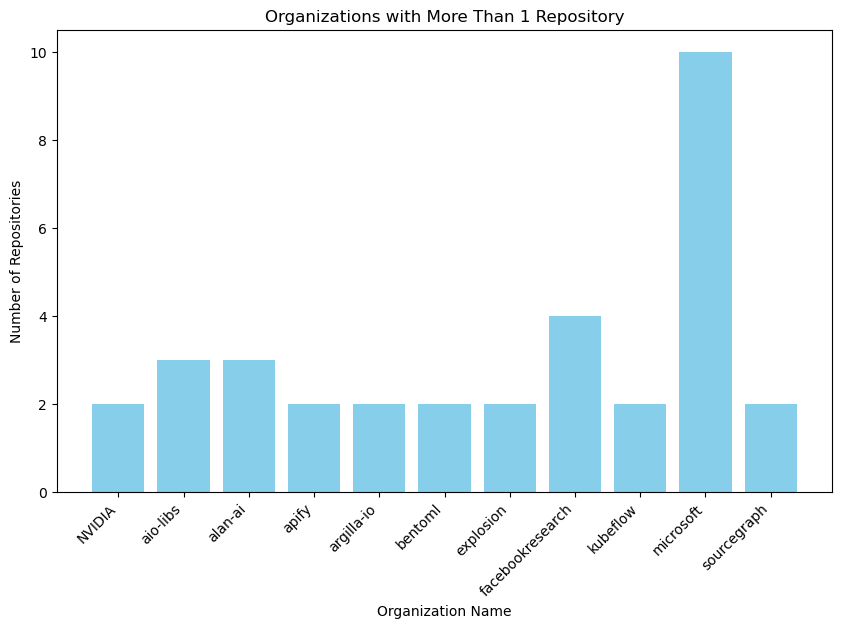

In [6765]:
# Are there orgs that have multiple repos?

org_repo_count = df.groupby('org_name')['repo_name'].nunique().reset_index()
org_repo_count.columns = ['org_name', 'num_repos']
orgs_with_multiple_repos = org_repo_count[org_repo_count['num_repos'] > 1]

# Plot orgs that have more than one repos
plt.figure(figsize=(10, 6)) 
plt.bar(orgs_with_multiple_repos['org_name'], orgs_with_multiple_repos['num_repos'], color='skyblue')
plt.xlabel('Organization Name')
plt.ylabel('Number of Repositories')
plt.title('Organizations with More Than 1 Repository')
plt.xticks(rotation=45, ha='right')
plt.show()

In [6766]:
# Which repos have the highest number of open issues?

open_pull_requests_per_repo = df.groupby(['creation_date', 'update_date', 'org_name', 'repo_name', 'num_pull_requests'])['num_open_issues'].sum().reset_index()
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo.sort_values(by='num_open_issues', ascending=False)
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo_sorted.reset_index(drop=True)

open_pull_requests_per_repo_sorted.head(20)

,creation_date,update_date,org_name,repo_name,num_pull_requests,num_open_issues
0,2022-12-07 09:43:02+00:00,2024-09-29 18:55:56+00:00,lencx,ChatGPT,1,5193
1,2015-08-24 07:27:28+00:00,2024-09-29 11:46:47+00:00,sourcegraph,sourcegraph-public-snapshot,43229,4591
2,2015-08-24 07:27:28+00:00,2024-09-29 11:46:47+00:00,sourcegraph,sourcegraph-public-snapshot,38682,4590
3,2015-09-06 04:01:52+00:00,2024-09-29 20:21:05+00:00,pingcap,tidb,35472,4457
4,2015-09-06 04:01:52+00:00,2024-09-29 20:21:05+00:00,pingcap,tidb,37599,4431
5,2015-08-24 07:27:28+00:00,2024-09-29 11:46:47+00:00,sourcegraph,sourcegraph-public-snapshot,40164,4420
6,2015-09-06 04:01:52+00:00,2024-09-29 20:21:05+00:00,pingcap,tidb,39118,4397
7,2015-09-06 04:01:52+00:00,2024-09-29 20:21:05+00:00,pingcap,tidb,33914,4295
8,2015-08-24 07:27:28+00:00,2024-09-29 11:46:47+00:00,sourcegraph,sourcegraph-public-snapshot,36840,4174
9,2016-10-25 19:38:30+00:00,2024-09-29 21:58:47+00:00,ray-project,ray,29812,4171


In [6767]:
# How many unique topics are there

print("Number of unique labels:", len(df.topics))
print("-"*100)
print("Unique topics:", list(df.topics)[:20])


Number of unique labels: 8718
----------------------------------------------------------------------------------------------------
Unique topics: ['python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'python-3, asyncio, redis, redis-sentinel, python, redis-client, aioredis, python3, python36, python37, python38, python39, hacktoberfest, python310', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, postgresql, sqlalchemy', 'asyncio, mysql, mariadb, sqlalchemy, p

Top Ten Recurrent Topics:
topics_split
ai                         4494
python                     2014
llm                        2000
machine-learning           1861
openai                     1644
chatgpt                    1498
deep-learning              1097
artificial-intelligence     990
gpt                         961
gpt-4                       886
pytorch                     797
data-science                751
rag                         682
chatbot                     681
hacktoberfest               616
llmops                      581
generative-ai               564
ml                          563
mlops                       545
tensorflow                  540
Name: count, dtype: int64


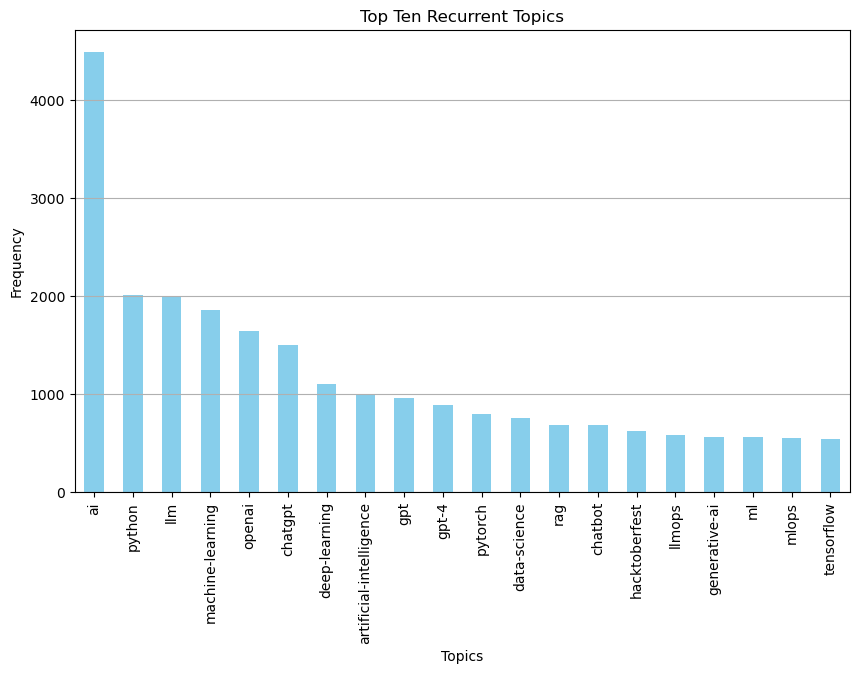

In [6768]:
# What are the most recurrent topics 

topics_count_df = df.copy()

# Split the topics column by commas
topics_count_df['topics_split'] = topics_count_df['topics'].str.split(', ')

# Explode the list of topics into individual rows
df_exploded = topics_count_df.explode('topics_split')

# Count the frequency of each topic
topic_counts = df_exploded['topics_split'].value_counts()

# Get the top ten recurrent topics
top_topics = topic_counts.head(20)

# Display the top ten topics
print("Top Ten Recurrent Topics:")
print(top_topics)

# Visualize the top ten topics
plt.figure(figsize=(10, 6))
top_topics.plot(kind='bar', color='skyblue')
plt.title('Top Ten Recurrent Topics')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

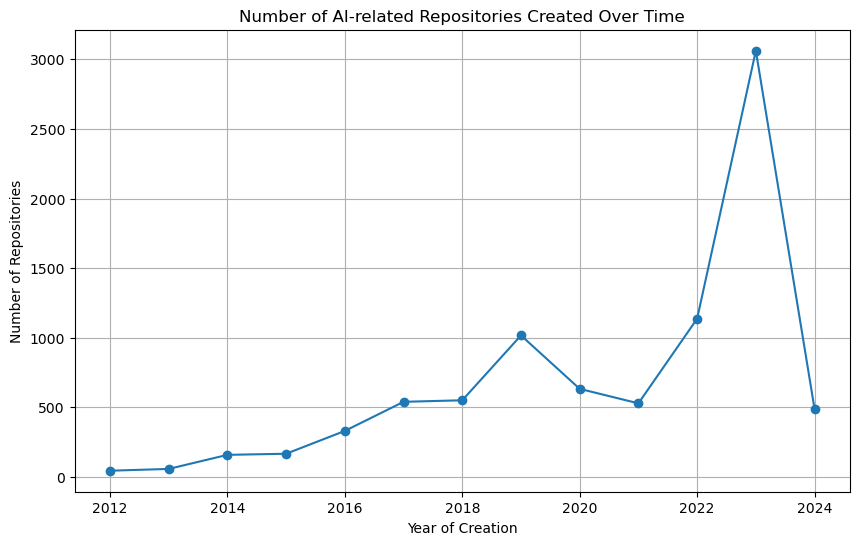

In [6769]:
# Visualizing the progression of AI-related repos creation
df_creation = df.copy()
df_creation['creation_date'] = pd.to_datetime(df['creation_date'])

# Sort the DataFrame by 'creation_date' in ascending order
df_sorted = df_creation.sort_values(by='creation_date')

# Group by year see a trend over time
df_sorted['creation_year'] = df_sorted['creation_date'].dt.year
df_grouped = df_sorted.groupby('creation_year').size().reset_index(name='repo_count')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['creation_year'], df_grouped['repo_count'], marker='o')
plt.title('Number of AI-related Repositories Created Over Time')
plt.xlabel('Year of Creation')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

How many repos have 30 releases?  org_name             218
repo_name            218
description          218
repo_url             218
topics               218
creation_date        218
update_date          218
release_tag          218
release_date         218
num_releases         218
num_open_issues      218
num_pull_requests    218
num_stars            218
num_forks            218
num_watchers         218
dtype: int64


<Figure size 2000x2000 with 0 Axes>

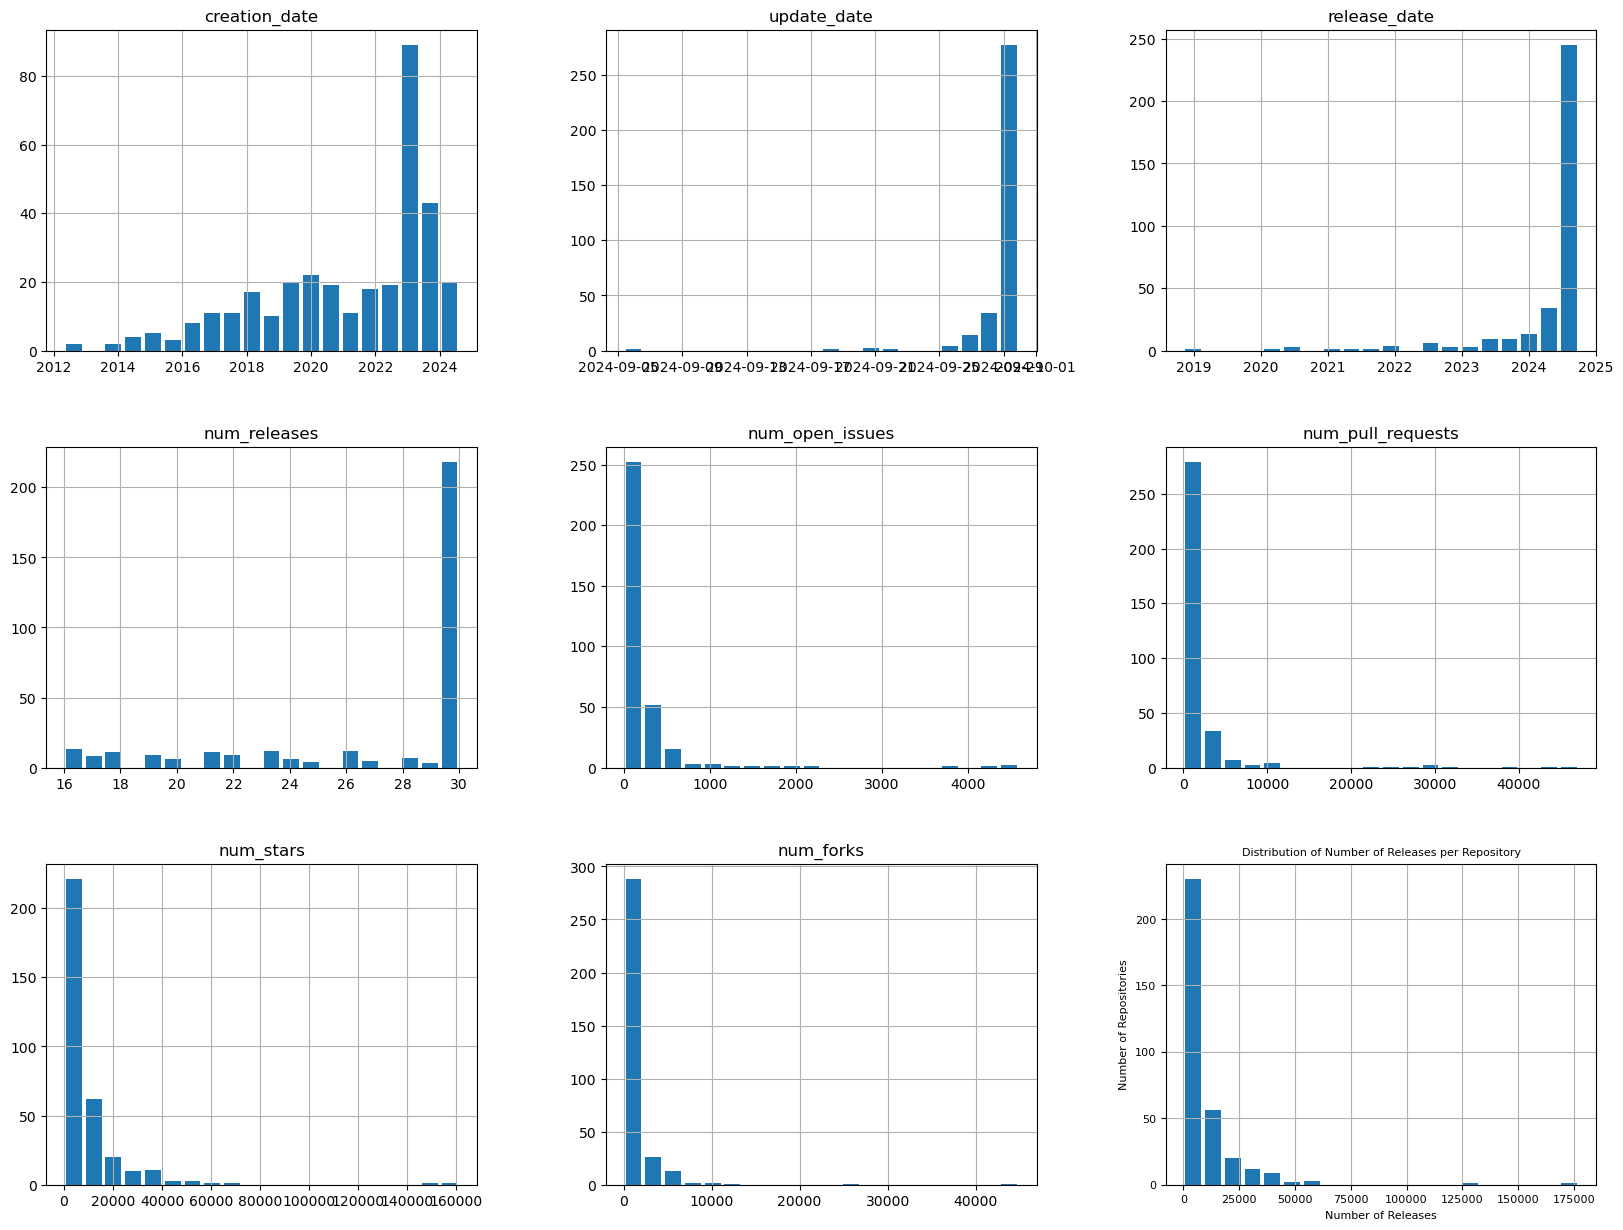

       num_releases  num_open_issues  num_pull_requests      num_stars  \
count    334.000000       334.000000         334.000000     334.000000   
mean      27.101796       231.287425        2039.275449    9540.332335   
std        4.587010       514.936051        5529.837429   15636.592205   
min       16.000000         1.000000           1.000000       1.000000   
25%       24.000000         4.750000           1.000000    1724.500000   
50%       30.000000       119.000000         816.000000    5649.500000   
75%       30.000000       226.750000        1542.500000   10581.250000   
max       30.000000      4591.000000       47174.000000  161166.000000   

          num_forks   num_watchers  
count    334.000000     334.000000  
mean    1358.095808    9447.694611  
std     3241.005034   15563.513105  
min        1.000000       1.000000  
25%       85.500000    1597.750000  
50%      639.500000    5676.000000  
75%     1262.750000   10594.250000  
max    44933.000000  177127.000000  


In [6770]:
# How many releases are there per repo?

# Since the total number of release is at the last row of every repo we want to get that last row
df_sorted = df.sort_values(by=['repo_name', 'release_date'], ascending=[True, True])
last_rows_num_release = df_sorted.drop_duplicates(subset='repo_name', keep='last')

print('How many repos have 30 releases? ',  last_rows_num_release[last_rows_num_release['num_releases'] == 30].count())


plt.figure(figsize=(20, 20))
last_rows_num_release.hist(bins=20, rwidth=0.8, layout=(3, 3), figsize=(20, 15))
plt.xlabel('Number of Releases', fontsize=8)
plt.ylabel('Number of Repositories', fontsize=8)
plt.title('Distribution of Number of Releases per Repository', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

print(last_rows_num_release.describe())


## Feature Engineering & Per-processing

In [6771]:
df_main = df.copy()

In [6772]:
columns_to_drop = ['description', 'release_tag', 'repo_url', 'update_date']
df_main.drop(columns=columns_to_drop, inplace=True)


df_main.head()

,org_name,repo_name,topics,creation_date,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers
0,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-07-07 08:16:11+00:00,1,47,386,2005,278,1886
1,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-07-31 07:52:08+00:00,2,70,564,2951,393,2845
2,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-08-08 07:51:11+00:00,3,94,923,3604,477,3680
3,aio-libs-abandoned,aioredis-py,"python-3, asyncio, redis, redis-sentinel, pyth...",2014-05-25 19:29:57+00:00,2014-09-22 19:50:09+00:00,4,111,979,4382,601,4117
4,aio-libs,aiopg,"asyncio, postgresql, sqlalchemy",2014-04-03 09:58:33+00:00,2014-10-02 09:33:16+00:00,1,113,979,4915,676,4489


I want to create a new `growth_score` dependent variable which will be based on `num_stars` + `num_forks` + `num_pull_requests`
but first I need to scale those values because they are very different from each other.

In [6773]:
df_main= add_growth_score_based_on_main_features(df_main)

df_main['growth_score'].tail()

8713    1.762149
8714    1.832407
8715    1.223529
8716    1.315713
8717    1.192186
Name: growth_score, dtype: float64

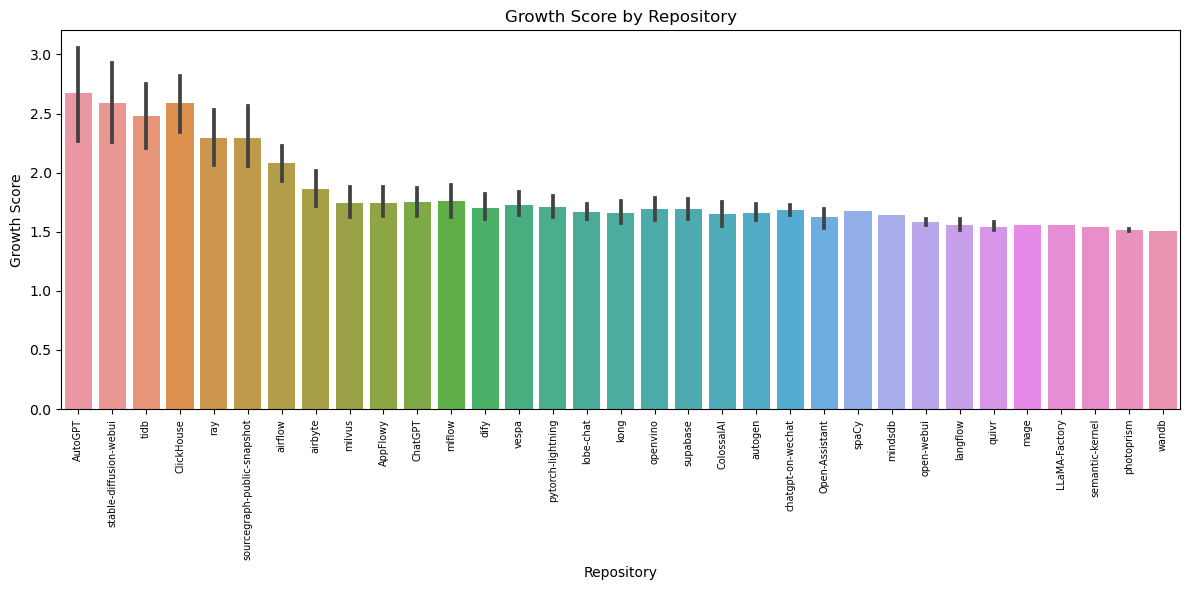

In [6774]:
df_filtered = df_main[df_main['growth_score'] > 1.5]

# Set the figure size
plt.figure(figsize=(12, 6))

# Bar plot showing growth_score for each repository
sns.barplot(x='repo_name', y='growth_score', data=df_filtered.sort_values(by='growth_score', ascending=False))

# Rotate x-axis labels for readability
plt.xticks(rotation=90, size=7)

# Add labels and title
plt.xlabel('Repository')
plt.ylabel('Growth Score')
plt.title('Growth Score by Repository')

# Show the plot
plt.tight_layout()
plt.show()

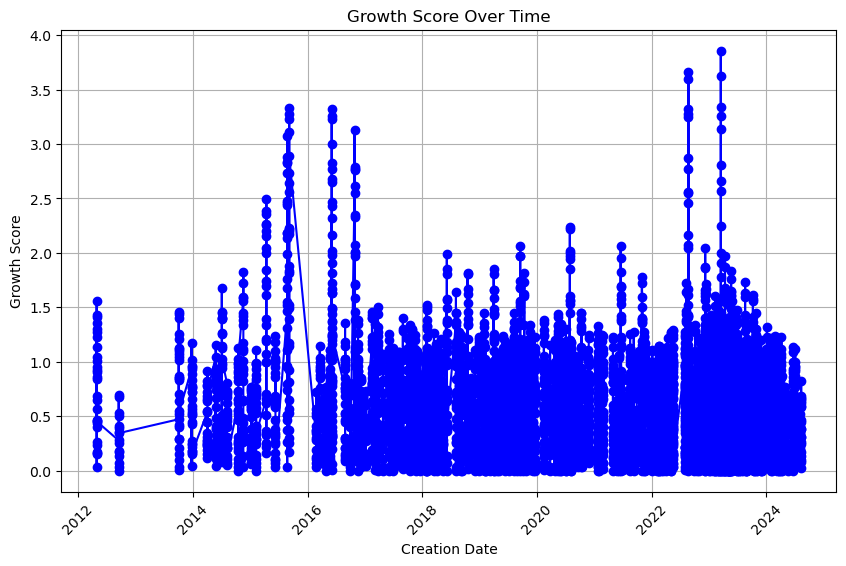

In [6775]:
# Plot the growth score

# Sort the DataFrame by creation date to plot correctly
df_main = df_main.sort_values(by='creation_date')

# Plot growth_score over time
plt.figure(figsize=(10, 6))
plt.plot(df_main['creation_date'], df_main['growth_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Creation Date')
plt.ylabel('Growth Score')
plt.title('Growth Score Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

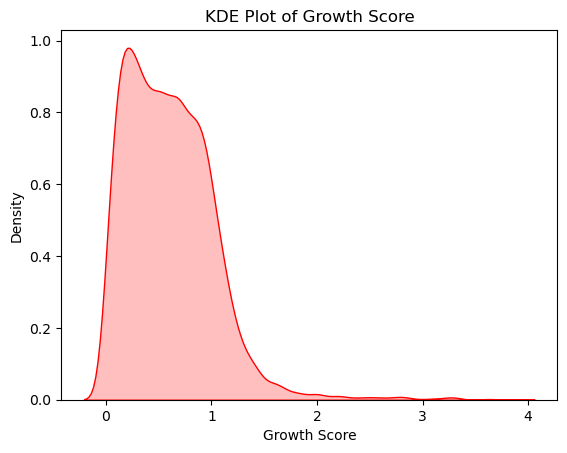

In [6776]:
sns.kdeplot(df_main['growth_score'], shade=True, color="r")
plt.title('KDE Plot of Growth Score')
plt.xlabel('Growth Score')
plt.ylabel('Density')
plt.show()

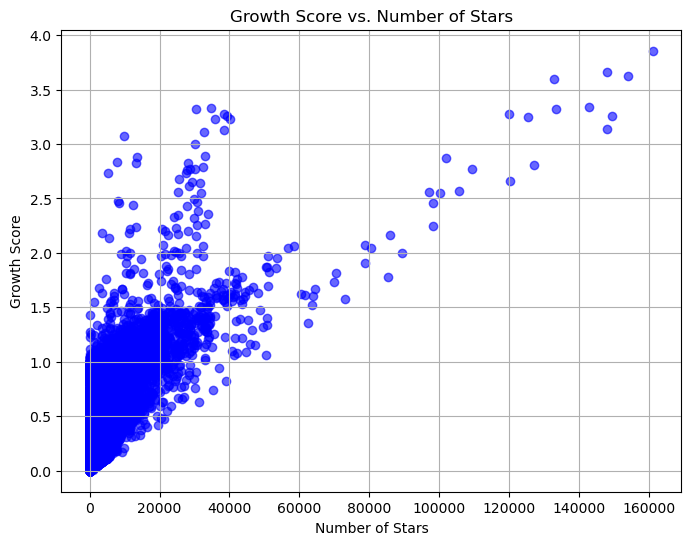

In [6777]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_stars'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Stars')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Stars')

plt.grid(True)
plt.show()

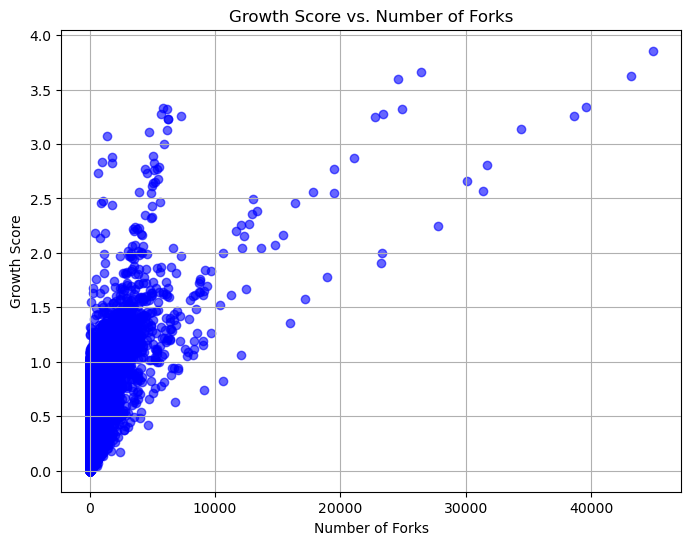

In [6778]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_forks'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Forks')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Forks')

plt.grid(True)
plt.show()

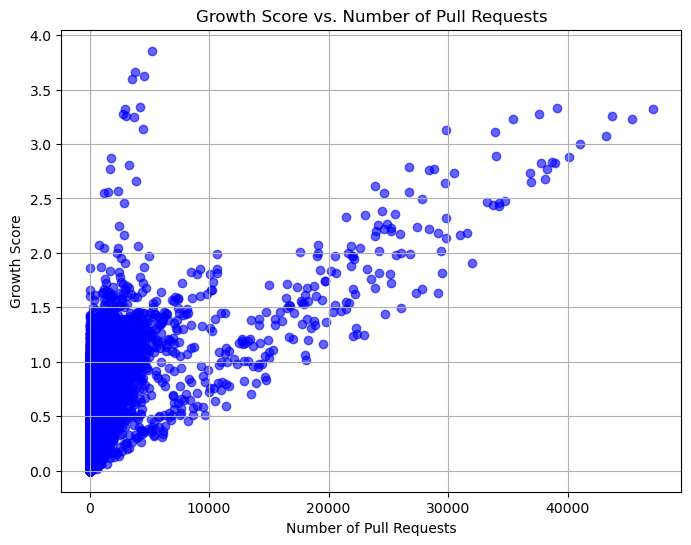

In [6779]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_pull_requests'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Pull Requests')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Pull Requests')

plt.grid(True)
plt.show()

In [6780]:
def load_or_generate_embeddings(df, embeddings_file='../data/topic_embeddings.csv'):
    # Check if the CSV file with the embeddings exists
    if os.path.exists(embeddings_file):
        # If the file exists, load the embeddings from the CSV file
        print("Loading embeddings from CSV file...")
        df_with_embeddings = pd.read_csv(embeddings_file)
    else:
        # If the file doesn't exist, generate the embeddings
        print("Generating topic embeddings...")
        df_with_embeddings = convert_topics_to_embeddings(df)
        
        # Save the embeddings to a CSV file
        df_with_embeddings.to_csv(embeddings_file, index=False)
    
    return df_with_embeddings

In [6781]:
df_main = load_or_generate_embeddings(df_main)
df_main.head()

Loading embeddings from CSV file...


,org_name,repo_name,creation_date,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,...,374,375,376,377,378,379,380,381,382,383
0,magefree,mage,2012-04-27 13:18:34+00:00,2020-07-10 15:58:43+00:00,12,660,2523,2188,565,2542,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
1,magefree,mage,2012-04-27 13:18:34+00:00,2020-02-01 10:15:26+00:00,6,224,145,1,1,1,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
2,magefree,mage,2012-04-27 13:18:34+00:00,2020-01-09 05:25:28+00:00,3,117,278,1,1,1,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
3,magefree,mage,2012-04-27 13:18:34+00:00,2020-02-15 12:37:05+00:00,7,373,1601,1718,341,1589,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011
4,magefree,mage,2012-04-27 13:18:34+00:00,2020-02-21 09:08:13+00:00,8,534,2324,4879,826,4994,...,0.117142,0.070474,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011


I want also to introduce 2 new features `repo_age_days` and `days_since_last_release` in order to better help the model recognize temporal data

In [6782]:
df_main = add_repo_age_days_col(df_main)
df_main = add_days_since_last_release_col(df_main)

df_main.head()

,org_name,repo_name,release_date,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
0,magefree,mage,2020-07-10 15:58:43+00:00,12,660,2523,2188,565,2542,0.609858,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4538,1542
1,magefree,mage,2020-02-01 10:15:26+00:00,6,224,145,1,1,1,0.221175,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4538,1702
2,magefree,mage,2020-01-09 05:25:28+00:00,3,117,278,1,1,1,0.098684,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4538,1725
3,magefree,mage,2020-02-15 12:37:05+00:00,7,373,1601,1718,341,1589,0.345077,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4538,1688
4,magefree,mage,2020-02-21 09:08:13+00:00,8,534,2324,4879,826,4994,0.478810,...,0.056391,-0.066624,0.037222,-0.044244,0.05621,0.0316,-0.004359,0.056011,4538,1682


After training the model, I noticed that there are lots of spikes related to the target variable, reducing those outliers should help the model fit better.

<Axes: xlabel='growth_score'>

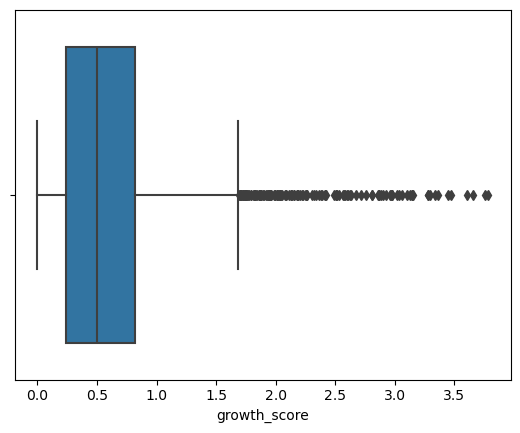

In [6783]:
# Checking for outliers
sns.boxplot(x=df_main['growth_score'])

In [6784]:
def detect_outliers_z_score(df, column):
    # the threshold determines the removal of the outliers that are over the specified threshold value
    threshold = 3
    mean = np.mean(df[column])
    std = np.std(df[column])
    z_scores = (df[column] - mean) / std
    return df[np.abs(z_scores) > threshold]

# Detect outliers in the 'growth_score' column
outliers = detect_outliers_z_score(df_main, 'growth_score')
print(len(outliers))
print(outliers)

108
                  org_name repo_name              release_date  num_releases  \
279                   Kong      kong 2024-09-11 09:19:15+00:00            30   
344                 apache   airflow 2024-07-16 11:30:52+00:00            26   
346                 apache   airflow 2024-08-16 01:53:36+00:00            28   
347                 apache   airflow 2024-06-10 10:58:26+00:00            24   
351                 apache   airflow 2024-04-08 12:11:00+00:00            22   
...                    ...       ...                       ...           ...   
6798  Significant-Gravitas   AutoGPT 2023-07-11 22:01:35+00:00            15   
6799  Significant-Gravitas   AutoGPT 2023-06-27 10:03:51+00:00            13   
6800  Significant-Gravitas   AutoGPT 2023-07-19 18:18:47+00:00            16   
6802  Significant-Gravitas   AutoGPT 2024-04-26 20:15:57+00:00            21   
6803  Significant-Gravitas   AutoGPT 2023-06-28 08:16:40+00:00            14   

      num_open_issues  num_pull_req

In [6785]:
# Remove outliers detected by the previous step
df_cleaned = df_main[~df_main.index.isin(outliers.index)]

<Axes: xlabel='growth_score'>

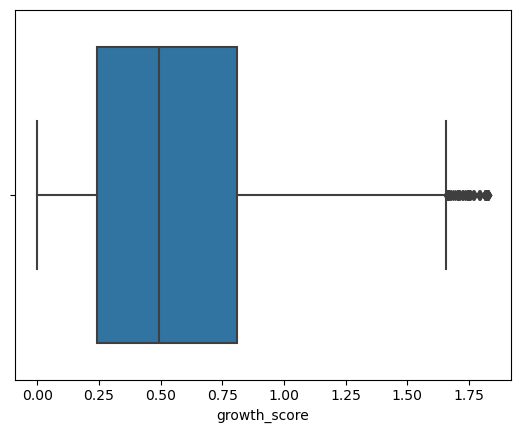

In [6786]:
sns.boxplot(x=df_cleaned['growth_score'])

In [6787]:
df_cleaned = indexify_release_dates(df_cleaned)
df_cleaned.head()

,org_name,repo_name,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
release_date,,,,,,,,,,,,,,,,,,,,,
2013-08-09 19:12:50+00:00,vim-airline,vim-airline,1,28,252,2424,237,2534,0.046334,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4109,4069
2013-08-12 22:07:03+00:00,vim-airline,vim-airline,2,59,526,5418,498,5199,0.133149,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4109,4066
2013-08-26 17:01:52+00:00,vim-airline,vim-airline,3,73,721,7850,645,7676,0.207839,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4109,4052
2013-09-09 14:19:37+00:00,vim-airline,vim-airline,4,85,1019,10382,949,10072,0.287835,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4109,4038
2013-10-10 17:59:55+00:00,vim-airline,vim-airline,6,111,1243,11931,1067,12908,0.396676,0.041241,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4109,4007


## Timeseries Analysis

Text(0.5, 1.0, 'Release Dates Over Time')

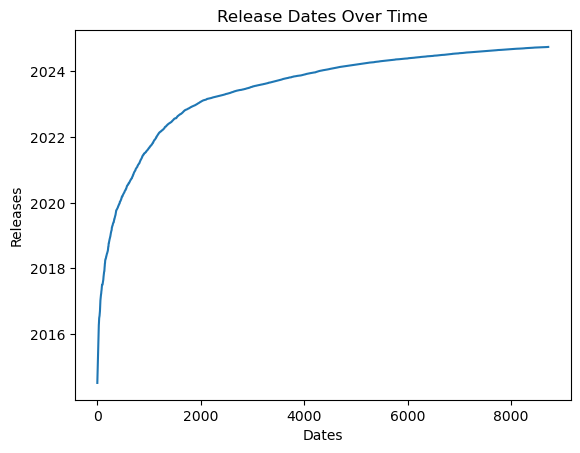

In [6788]:
df['release_date'].plot()
plt.xlabel('Dates')
plt.ylabel('Releases')
plt.title('Release Dates Over Time')

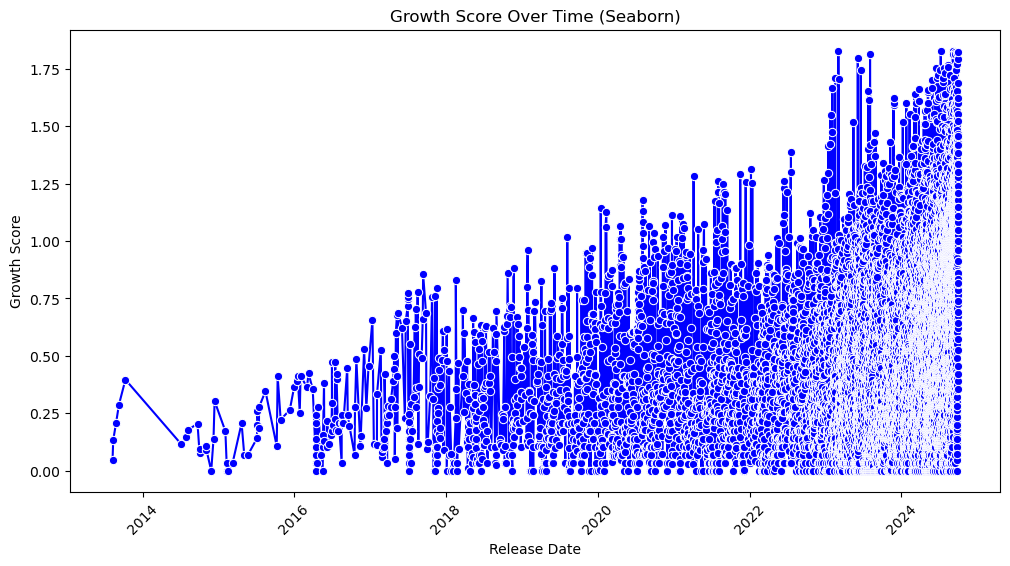

In [6789]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_cleaned.index, y=df_cleaned['growth_score'], marker='o', color='b')
plt.title('Growth Score Over Time (Seaborn)')
plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.xticks(rotation=45)
plt.show()

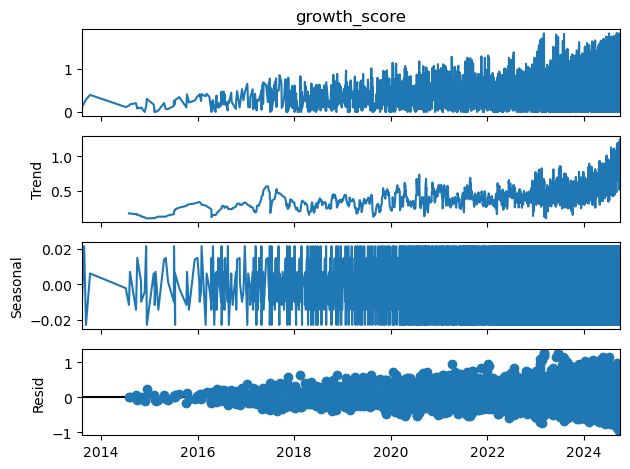

In [6790]:
# Decompose the time series
decomposition = seasonal_decompose(df_cleaned['growth_score'], model='additive', period=12)

# Plot the decomposed components
decomposition.plot()
plt.show()

In [6791]:
print(last_rows_num_release.describe()) 

       num_releases  num_open_issues  num_pull_requests      num_stars  \
count    334.000000       334.000000         334.000000     334.000000   
mean      27.101796       231.287425        2039.275449    9540.332335   
std        4.587010       514.936051        5529.837429   15636.592205   
min       16.000000         1.000000           1.000000       1.000000   
25%       24.000000         4.750000           1.000000    1724.500000   
50%       30.000000       119.000000         816.000000    5649.500000   
75%       30.000000       226.750000        1542.500000   10581.250000   
max       30.000000      4591.000000       47174.000000  161166.000000   

          num_forks   num_watchers  
count    334.000000     334.000000  
mean    1358.095808    9447.694611  
std     3241.005034   15563.513105  
min        1.000000       1.000000  
25%       85.500000    1597.750000  
50%      639.500000    5676.000000  
75%     1262.750000   10594.250000  
max    44933.000000  177127.000000  


In [6792]:
# Since the min num_release is 6 of I'll create 5 lag features. Otherwise a higher number will lead to lots of NaN values.
n_lag_features = 5
df_cleaned_with_lag = add_lag_features_based_on_target(df_cleaned, num=n_lag_features)
print(df_cleaned_with_lag.shape)
df_cleaned_with_lag.head()


(9612, 400)


,org_name,repo_name,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,...,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4,growth_score_lag_5
release_date,,,,,,,,,,,,,,,,,,,,,
2014-07-07 08:16:11+00:00,aio-libs-abandoned,aioredis-py,1,100,976,4707,675,4900,0.114623,-0.051876,...,0.051719,0.054389,0.041278,3780,3737,0.396676,0.287835,0.207839,0.133149,0.046334
2014-07-31 07:52:08+00:00,aio-libs-abandoned,aioredis-py,2,112,1017,4303,610,4502,0.146138,-0.051876,...,0.051719,0.054389,0.041278,3780,3713,0.114623,0.396676,0.287835,0.207839,0.133149
2014-08-08 07:51:11+00:00,aio-libs-abandoned,aioredis-py,3,102,1049,4335,609,4235,0.177709,-0.051876,...,0.051719,0.054389,0.041278,3780,3705,0.146138,0.114623,0.396676,0.287835,0.207839
2014-09-22 19:50:09+00:00,aio-libs-abandoned,aioredis-py,4,101,898,3955,600,4037,0.205077,-0.051876,...,0.051719,0.054389,0.041278,3780,3660,0.177709,0.146138,0.114623,0.396676,0.287835
2014-10-02 09:33:16+00:00,aio-libs,aiopg,1,82,703,3202,430,3022,0.078954,-0.040947,...,-0.011810,0.087497,-0.039265,3832,3650,0.205077,0.177709,0.146138,0.114623,0.396676


In [6793]:
# Perform the ADF test
result = adfuller(df_cleaned_with_lag['growth_score'].dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.746750373529747
p-value: 6.868581705592197e-05


The data is stationary:
-  the ADF statistic of -4.53 is quite negative, which strongly suggests that your time series data is stationary.
- Since the p-value is much lower than the usual significance level of 0.05, we can reject the null hypothesis that the data is non-stationary. This confirms that your data is stationary.

In [6794]:
# Remove no-longer needed features
df_cleaned_with_lag = df_cleaned_with_lag.drop(columns=['org_name', 'repo_name'])
print(df_cleaned_with_lag.shape)
df_cleaned_with_lag.head()


(9612, 398)


,num_releases,num_open_issues,num_pull_requests,num_stars,num_forks,num_watchers,growth_score,0,1,2,...,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4,growth_score_lag_5
release_date,,,,,,,,,,,,,,,,,,,,,
2014-07-07 08:16:11+00:00,1,100,976,4707,675,4900,0.114623,-0.051876,-0.103019,-0.099194,...,0.051719,0.054389,0.041278,3780,3737,0.396676,0.287835,0.207839,0.133149,0.046334
2014-07-31 07:52:08+00:00,2,112,1017,4303,610,4502,0.146138,-0.051876,-0.103019,-0.099194,...,0.051719,0.054389,0.041278,3780,3713,0.114623,0.396676,0.287835,0.207839,0.133149
2014-08-08 07:51:11+00:00,3,102,1049,4335,609,4235,0.177709,-0.051876,-0.103019,-0.099194,...,0.051719,0.054389,0.041278,3780,3705,0.146138,0.114623,0.396676,0.287835,0.207839
2014-09-22 19:50:09+00:00,4,101,898,3955,600,4037,0.205077,-0.051876,-0.103019,-0.099194,...,0.051719,0.054389,0.041278,3780,3660,0.177709,0.146138,0.114623,0.396676,0.287835
2014-10-02 09:33:16+00:00,1,82,703,3202,430,3022,0.078954,-0.040947,-0.042826,-0.129569,...,-0.011810,0.087497,-0.039265,3832,3650,0.205077,0.177709,0.146138,0.114623,0.396676


In [6795]:
df_cleaned_with_lag['growth_score'].describe()

count    9612.000000
mean        0.547658
std         0.367685
min         0.000000
25%         0.241379
50%         0.492728
75%         0.809025
max         1.828825
Name: growth_score, dtype: float64

In [6796]:
df_cleaned_with_lag['growth_score'] = np.log1p(df_cleaned_with_lag['growth_score'])

In [6797]:
df_cleaned_with_lag['growth_score'].describe()

count    9612.000000
mean        0.409346
std         0.233086
min         0.000000
25%         0.216223
50%         0.400606
75%         0.592788
max         1.039862
Name: growth_score, dtype: float64

In [6798]:
df_cleaned_with_lag['growth_score']

release_date
2014-07-07 08:16:11+00:00    0.108516
2014-07-31 07:52:08+00:00    0.136398
2014-08-08 07:51:11+00:00    0.163571
2014-09-22 19:50:09+00:00    0.186544
2014-10-02 09:33:16+00:00    0.075992
                               ...   
2024-09-29 18:41:06+00:00    1.027047
2024-09-29 19:05:51+00:00    1.037531
2024-09-29 20:07:00+00:00    0.806617
2024-09-29 20:19:03+00:00    0.833492
2024-09-29 21:25:06+00:00    0.793136
Name: growth_score, Length: 9612, dtype: float64

## Model Development

In [6799]:
# Define the input and target variables
X = df_cleaned_with_lag.drop(columns=['growth_score']).values
y = df_cleaned_with_lag['growth_score'].values

X.shape

(9612, 397)

In [6800]:
# Split the data into testing and training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6801]:
# Scale the input variables
scaler_X = MinMaxScaler()
# Fit the scaler only on the training data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
joblib.dump(scaler_X, '../models/final_input_scaler.pkl')


# Scale the target variable as well
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
joblib.dump(scaler_y, '../models/final_target_scaler.pkl')

print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(7689, 397)
(7689, 1)
(1923, 397)
(1923, 1)


Explained variance ratio by PCA: 0.95


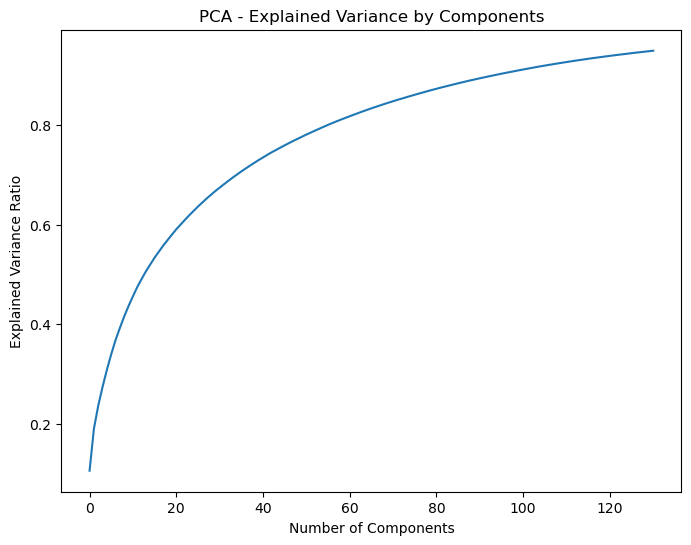

(7689, 131)


In [6802]:
# Set the number of components to retain - 95% of features
pca = PCA(n_components=0.95)

# Fit PCA on training data and transform both train and test sets
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
joblib.dump(pca, '../models/pca_model.pkl')

print(f'Explained variance ratio by PCA: {np.sum(pca.explained_variance_ratio_):.2f}')

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance by Components')
plt.show()

print(X_train_scaled_pca.shape)

After PCA the features were reduced from 397 to 131 features while still explaining 95% of the variance in the original data.

In [6803]:
# Defining the num of timesteps and num of features

n_timesteps = 5
n_features_pca = X_train_scaled_pca.shape[1]
input_shape = (n_timesteps, n_features_pca)


In [6804]:
# Define the hypermodel for GRU model - this is a Gridsearch functionality to find the best values for the hyper parameters
class GRUHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Input layer
        input_layer = Input(shape=self.input_shape)
        
        # GRU layer with return_sequences=True for the Attention mechanism
        gru_out = GRU(units=hp.Int('units', min_value=16, max_value=256, step=16),
                      return_sequences=True)(input_layer)
        
        # Attention layer
        attention_out = Attention()([gru_out, gru_out])  # Self-attention

        # Optionally, concatenate the attention output with GRU output
        combined_out = Concatenate()([gru_out, attention_out])

        # Flatten the combined output for feeding into Dense layers
        combined_out = Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
                             activation='relu')(combined_out)

        # Dropout layer for regularization
        x = Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1))(combined_out)
        
        # Output layer for regression
        output = Dense(1)(x)
        
        # Define the model with the input and output layers
        model = Model(inputs=input_layer, outputs=output)

        # Compile the model with the optimizer and loss function
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate',
                                                            min_value=1e-5,
                                                            max_value=1e-2,
                                                            sampling='LOG')),
                      loss='mean_squared_error')
        return model


In [6805]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(
            LSTM(
                units=hp.Int("units", min_value=16, max_value=256, step=16),
                return_sequences=False,
                input_shape=self.input_shape,
                activation='relu'
            )
        )
        model.add(
            Dropout(
                rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
            )
        )
        model.add(Dense(10, activation='relu'))
        model.add(
            Dense(
                1,
                activation='exponential'  # For regression tasks, linear activation is used
            )
        )

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Float("learning_rate", min_value=1e-7, max_value=0.001, sampling="LOG")
            ),
            loss="mean_squared_error"
        )
        return model

In [6806]:
def create_lstm_model(input_shape, learning_rate=1e-6, lstm_units=256, dropout_rate=0.5):
    # Input layer
    input_layer = Input(shape=input_shape)
    # LSTM layer with return_sequences=True to output the full sequence
    lstm_out = LSTM(units=lstm_units, return_sequences=True)(input_layer)
    attention_out = Attention()([lstm_out, lstm_out])
    # Flatten the attention output and concatenate with LSTM output
    combined_out = Concatenate()([lstm_out, attention_out]) 
    x = Dense(10, activation='relu')(combined_out)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='exponential')(x)  # Output layer for regression
    model = Model(inputs=input_layer, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

    # model = Sequential()
    
    # # First LSTM layer
    # model.add(LSTM(units=lstm_units, return_sequences=False, input_shape=input_shape))
    # model.add(Dropout(dropout_rate))
    # model.add(Dense(10, activation='relu'))
    # # Output layer (Dense layer with 1 unit because it's regression)
    # model.add(Dense(1, activation='exponential'))

    # # Compile the model with Adam optimizer and a custom learning rate
    # optimizer = Adam(learning_rate=learning_rate)
    # model.compile(optimizer=optimizer, loss='mean_squared_error')

    # return model

In [6807]:
def create_gru_attention_model(input_shape, learning_rate=1e-4, gru_units=128, dropout_rate=0.5):

    input_layer = Input(shape=input_shape)
    gru_output = GRU(units=gru_units, return_sequences=True)(input_layer)
    gru_output = Dropout(dropout_rate)(gru_output)
    attention_output = Attention()([gru_output, gru_output])
    context_vector = Add()([gru_output, attention_output])
    context_vector = LayerNormalization()(context_vector)
    context_vector = context_vector[:, -1, :] 
    dense_output = Dense(64, activation='relu')(context_vector)
    dense_output = Dropout(dropout_rate)(dense_output)
    output = Dense(1, activation='exponential')(dense_output)  # Use 'linear' for regression tasks
    
    # Create model
    model = Model(inputs=input_layer, outputs=output)
    
    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [7075]:
# Make sure the model remain producing consistent results with the same params 
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Hyperparameters
batch_size = 32          #32 Controls the number of samples per gradient update, larger batch size = faster training but less frequent updates.
units = 208              #192 176  128 Number of units in GRU/LSTM layers, more units capture more complexity but may overfit if too large.
learning_rate= 1e-5      #1e-5 1e-4 Step size in updating weights, lower values lead to slower but more precise convergence.
dropout_rate = 0.01       #0.01 0.05 Fraction of input units to drop during training to prevent overfitting, lower rate means less regularization.
patience = 5             #5 Number of epochs with no improvement before early stopping, lower patience = earlier stopping.
epochs = 400             #400 Maximum number of times the entire dataset is passed through the model, more epochs = potential better fitting but risk of overfitting.



train_generator = TimeseriesGenerator(X_train_scaled_pca, y_train_scaled, length=n_timesteps, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test_scaled_pca, y_test_scaled, length=n_timesteps, batch_size=batch_size)

#### Grid Search

In [7076]:
hypermodel = GRUHyperModel(input_shape=input_shape)

# Set up the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=2,  # Number of trials to run
    executions_per_trial=10,  # Number of models to average for each trial
    directory='../models/grid_search_results/gru_tuning',  # Directory to save logs and models
    project_name='gru_tune')

# Run the search
# tuner.search(train_generator, validation_data=test_generator, epochs=100)

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best units: {best_hps.get('units')}")
print(f"Best dropout_rate: {best_hps.get('dropout_rate')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")

Reloading Tuner from ../models/grid_search_results/gru_tuning/gru_tune/tuner0.json
Best units: 192
Best dropout_rate: 0.4
Best learning_rate: 0.0009927306381483174


In [7077]:
# Commenting this out so that it doesn't run when "Run All" is pressed because it takes a very long time

# Set up the tuner
# tuner = RandomSearch(
#     LSTMHyperModel(input_shape),
#     objective="val_loss",
#     max_trials=10,  # Number of different hyperparameter combinations to try
#     executions_per_trial=1,  # Number of times to train the model with each hyperparameter set
#     directory="../models/grid_search_results/lstm_tuning",
#     project_name="lstm_hyperparameter_search"
# )

# tuner.search_space_summary()

# # Assuming you have your training and validation data prepared as train_generator and val_generator
# tuner.search(train_generator, validation_data=test_generator, epochs=100)

# # Get the best model and parameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"Best Hyperparameters: {best_hyperparameters.values}")

#### Model Training

In [7078]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# LSTM Model
# Best Hyperparameters: {'units': 192, 'dropout_rate': 0.2, 'learning_rate': 7.727252029218442e-05}
# model = create_lstm_model(input_shape=input_shape, learning_rate=learning_rate, lstm_units=units, dropout_rate=dropout_rate)

# GRU Model
# Best Hyperparameters: {'units': 64, 'dropout_rate': 0.05, 'learning_rate': 1e-5}
model = create_gru_attention_model(input_shape=input_shape, learning_rate=learning_rate, gru_units=units, dropout_rate=dropout_rate)

# Early stopping so it stops when the learning stops learning & saves the model with the best result
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../models/best_rnn_model.keras', save_best_only=True, monitor='val_loss')


# Reduce the learning rate by a factor of 0.01 if the validation loss does not improve for 1 consecutive epochs.
# The learning rate will not be reduced below 1e-5 to avoid excessively small updates.
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=1e-1, patience=2, min_lr=1e-9)

history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=test_generator, callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.4610 - val_loss: 4.6263 - learning_rate: 1.0000e-05
Epoch 2/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1802 - val_loss: 2.4844 - learning_rate: 1.0000e-05
Epoch 3/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9126 - val_loss: 1.5667 - learning_rate: 1.0000e-05
Epoch 4/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2847 - val_loss: 1.0859 - learning_rate: 1.0000e-05
Epoch 5/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8720 - val_loss: 0.8041 - learning_rate: 1.0000e-05
Epoch 6/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6710 - val_loss: 0.6190 - learning_rate: 1.0000e-05
Epoch 7/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4983 - val_loss: 0.4920 - learning_rate: 1.0000e-05
Epoch 8/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3999 - val_loss: 0.4029 - learning_rate: 1.0000e-05
Epoch 9/400
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3530 - val_loss: 

In [7079]:
# Load the saved model
model = load_model('../models/best_rnn_model.keras')

In [7080]:
model.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 5, 131)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_46 (GRU)        │ (None, 5, 208)    │    212,784 │ input_layer_46[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 5, 208)    │          0 │ gru_46[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_46        │ (None, 5, 208)    │          0 │ dropout_91[0][0], │
│ (Attention)         │                   │            │ dropout_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 5, 208)    │          0 │ dropout_91[0][0], │
│                     │                   │            │ attention_46[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 208)    │        416 │ add_45[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_45         │ (None, 208)       │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 64)        │     13,376 │ get_item_45[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 64)        │          0 │ dense_92[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 1)         │         65 │ dropout_92[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 679,925 (2.59 MB)

 Trainable params: 226,641 (885.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 453,284 (1.73 MB)

#### Model Evaluation

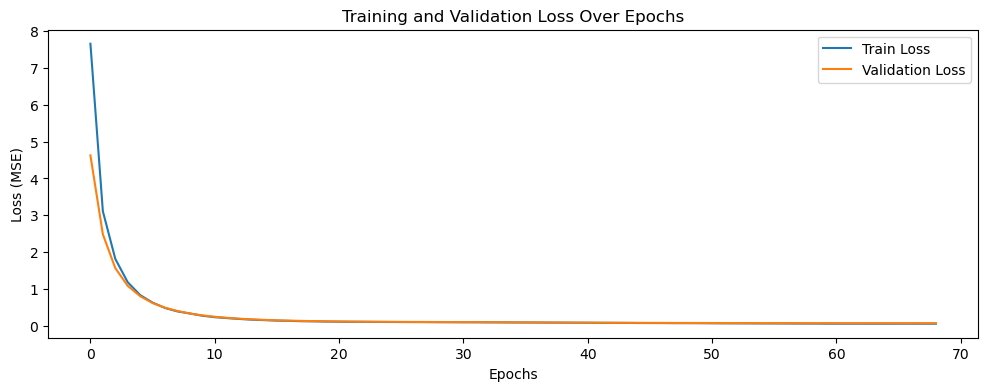

In [7081]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [7082]:
test_loss = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0725 
Test Loss: 0.07214964926242828


In [7083]:
scaler_y = joblib.load('../models/final_target_scaler.pkl')

y_pred_scaled = model.predict(test_generator)

# for GRU model and LSTM with return_sequences=False
y_pred = scaler_y.inverse_transform(y_pred_scaled).reshape(-1)

print(y_pred.shape)

# Initialize a list for the actual values
y_actual_scaled = []

# Extract actual values from test_generator
for i in range(len(test_generator)):
    _, target = test_generator[i]  # target is the true y values for the batch
    y_actual_scaled.append(target)

# # Flatten the array to match y_pred
y_actual_scaled = np.concatenate(y_actual_scaled).reshape(-1)

# Inverse transform the actual values
y_actual = scaler_y.inverse_transform(y_actual_scaled.reshape(-1, 1)).reshape(-1)

print(y_actual.shape)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual Growth Score': y_actual,
    'Predicted Growth Score': y_pred
})

# Save the DataFrame to a CSV file
results_df.to_csv('../results/predictions.csv', index=False)
print("The DataFrame has been saved as 'predictions.csv'")

# Display the DataFrame
print(results_df)

# Print one pair of actual vs predicted for verification
print(f'actual: {y_actual[-1]}', f' | predicted: {y_pred[-1]}')


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1918,)
(1918,)
The DataFrame has been saved as 'predictions.csv'
      Actual Growth Score  Predicted Growth Score
0                0.524524                0.505832
1                0.411232                0.482425
2                0.258537                0.461133
3                0.182758                0.730001
4                0.479366                0.499868
...                   ...                     ...
1913             0.270541                0.264829
1914             0.269317                0.668380
1915             0.032113                0.253373
1916             0.728570                0.390443
1917             0.741266                1.020854

[1918 rows x 2 columns]
actual: 0.7412661268693217  | predicted: 1.0208539962768555


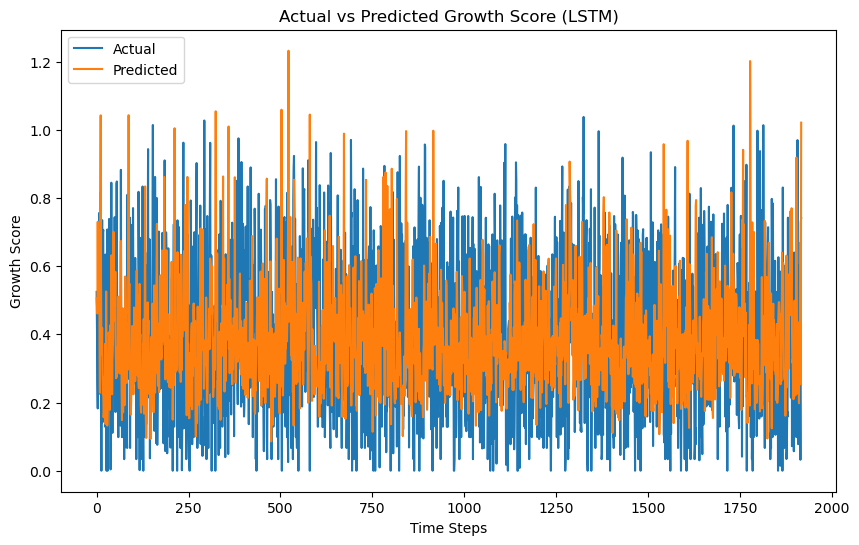

In [7084]:
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Growth Score')
plt.title('Actual vs Predicted Growth Score (LSTM)')
plt.legend()

plt.show()

Considering the model is overpredicting. For this reason it would be important to conduct a residual analysis to better understand the cause of this overprediction.

In [7085]:
residuals = y_actual - y_pred
print(residuals)

[ 0.01869269 -0.07119339 -0.20259645 ... -0.22125957  0.33812657
 -0.27958787]


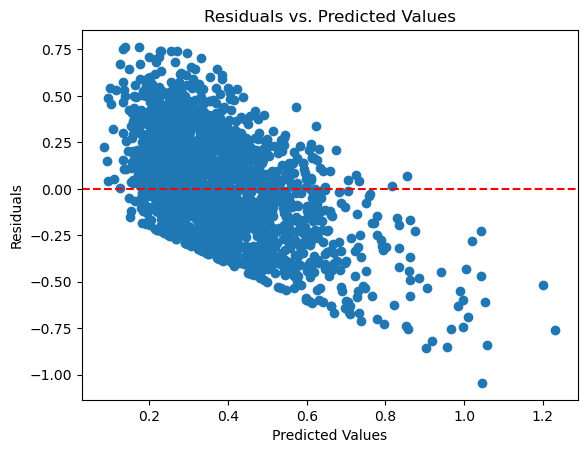

In [7086]:
# Residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Most of the points are below 0 indicating that the model is not a good fit, suggesting that there's a systematic error in the data.
There is a slight downward trend in the residuals, indicating that the errors are not randomly distributed around 0. This could suggest that there is some non-linearity in the relationship between the input and the target. 

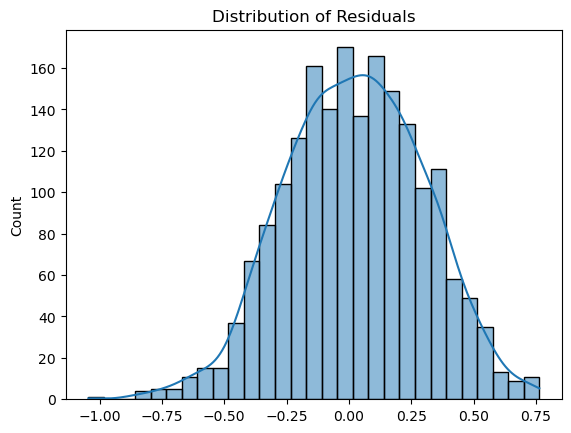

In [7087]:
# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

If residuals follow a bell-shaped curve centered around zero, the model’s errors are likely normally distributed.

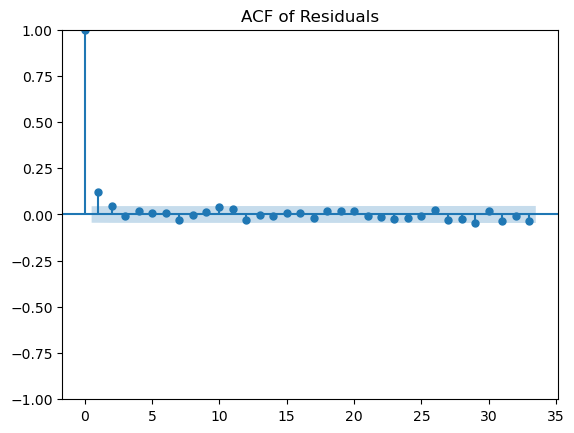

In [7088]:
# Plot autocorrelation of residuals
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

If the ACF plot shows significant spikes, it means the residuals are autocorrelated, suggesting the model is missing important temporal patterns.

In [7089]:
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print(f'y_actual: {y_actual.mean()}', f'y_pred: {y_pred.mean()}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')


y_actual: 0.40779219031078767 y_pred: 0.3841201364994049
MSE: 0.07801629268104623
MAE: 0.22633893841498573


__MSE__: 0.0585 - Indicates the average squared difference between predicted and actual growth scores. Lower is better.
__MAE__: 0.2029 - Shows the average absolute error between predictions and actual values. A lower value means better performance.

The model’s predictions are generally close to the actual values, but it tends to underestimate slightly. The errors suggest there's room for improvement, particularly in reducing prediction deviations.

#### Forecasting

In [7090]:
def forecast_growth(model, initial_data, n_steps, scaler, timesteps=5, n_features=133):

    forecasted_values = []
    input_seq = initial_data[-timesteps:]  # Start with the last available data
    
    for _ in range(n_steps):
        # Prepare the input by reshaping (3D: 1 × timesteps × features)
        input_seq_reshaped = input_seq.reshape(1, timesteps, n_features)

        # Predict the next step (3D output)
        next_pred_scaled = model.predict(input_seq_reshaped)

        # For GRU and LSTM model with return_sequences=False
        next_pred = scaler.inverse_transform(next_pred_scaled)

        # Append the forecasted value
        forecasted_values.append(next_pred[0, 0])
        
        # Create a new input sequence with the predicted value
        next_input = input_seq[-1].copy()  # Copy last row of input sequence
        next_input[-1] = next_pred[0, 0] 

        # Update the input sequence by shifting and appending the new prediction
        input_seq = np.concatenate([input_seq[1:], next_input.reshape(1, -1)], axis=0)  # Shift and append
    
    return np.array(forecasted_values)


n_forecast_steps = 12 
scaler_y = joblib.load('../models/final_target_scaler.pkl')
initial_data = X_test_scaled_pca[-n_timesteps:]

print(n_timesteps, n_features_pca) 
print(initial_data.shape) 
print(X_test_scaled_pca.shape)
print(X_test_scaled_pca[-n_timesteps:].shape)
print(y_test_scaled[-n_timesteps:].shape)
print(n_features_pca)

# Perform the forecasting using the GRU model with attention
forecasted_values = forecast_growth(
    model=model, 
    initial_data=initial_data, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=n_timesteps, 
    n_features=n_features_pca
)

# Print the forecasted growth scores
print("Forecasted Growth Scores:", forecasted_values)

5 131
(5, 131)
(1923, 131)
(5, 131)
(5, 1)
131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Forecasted Growth Scores: [0.46742743 0.6349056  0.815433   1.0071502  1.1400995  1.2325077
 1.3043237  1.3534701  1.3892331  1.4150361  1.4336544  1.4470323 ]


#### Ploting the Forecast

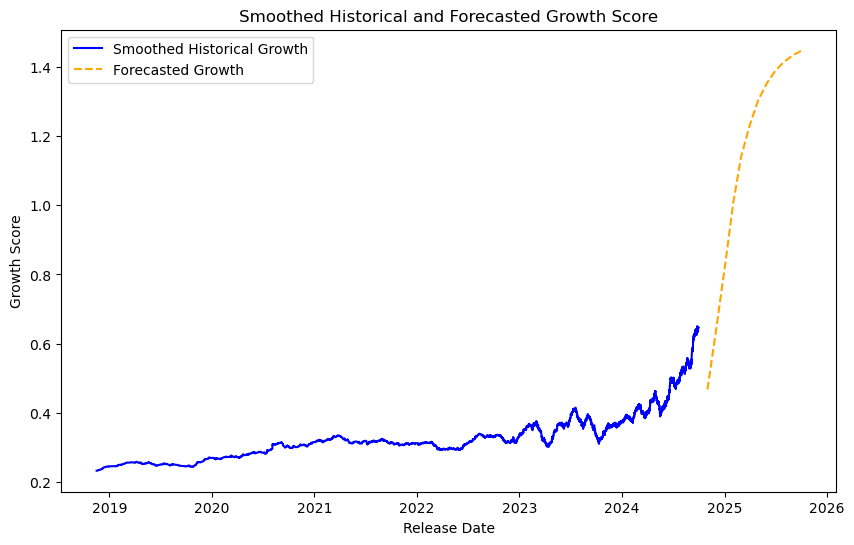

In [7091]:
# Generate future dates for the forecasted values based on the release_date index by Monthly frequency
forecasted_dates = pd.date_range(start=df_cleaned_with_lag.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]

# Apply a rolling average to smooth historical data because of the large data spikes
df_cleaned_with_lag['smoothed_growth_score'] = df_cleaned_with_lag['growth_score'].rolling(window=300).mean()

# Plot the smoothed historical growth score and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned_with_lag.index, df_cleaned_with_lag['smoothed_growth_score'], color='blue', label='Smoothed Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')

plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()